DESCRIPTION

One of the leading retail stores in the US, Walmart, would like to predict the sales and demand accurately. There are certain events and holidays which impact sales on each day. There are sales data available for 45 stores of Walmart. The business is facing a challenge due to unforeseen demands and runs out of stock some times, due to the inappropriate machine learning algorithm. An ideal ML algorithm will predict demand accurately and ingest factors like economic conditions including CPI, Unemployment Index, etc.

Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of all, which are the Super Bowl, Labour Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data. Historical sales data for 45 Walmart stores located in different regions are available.

Dataset Description

This is the historical data that covers sales from 2010-02-05 to 2012-11-01, in the file Walmart_Store_sales. Within this file you will find the following fields:

Store - the store number

Date - the week of sales

Weekly_Sales -  sales for the given store

Holiday_Flag - whether the week is a special holiday week 1 – Holiday week 0 – Non-holiday week

Temperature - Temperature on the day of sale

Fuel_Price - Cost of fuel in the region

CPI – Prevailing consumer price index

Unemployment - Prevailing unemployment rate

Holiday Events

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

Analysis Tasks

Basic Statistics tasks

Which store has maximum sales

Which store has maximum standard deviation i.e., the sales vary a lot. Also, find out the coefficient of mean to standard deviation

Which store/s has good quarterly growth rate in Q3’2012

Some holidays have a negative impact on sales. Find out holidays which have higher sales than the mean sales in non-holiday season for all stores together

Provide a monthly and semester view of sales in units and give insights

Statistical Model

For Store 1 – Build  prediction models to forecast demand

Linear Regression – Utilize variables like date and restructure dates as 1 for 5 Feb 2010 (starting from the earliest date in order). Hypothesize if CPI, unemployment, and fuel price have any impact on sales.

Change dates into days by creating new variable.

In [146]:
import seaborn as sns
from pandas import read_csv, DataFrame, to_datetime, get_dummies, to_timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
#Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment

#from statsmodels.api import OLS
#statsmodels.regression.linear_model
from statsmodels.regression.linear_model import OLS, OLSResults
from statsmodels.api import Logit
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
wm = read_csv('Walmart_Store_sales.csv', 
              dtype={'Store':'Int32','Weekly_Sales':'Float64',
                     'Holiday_Flag':'Int32','Temperature':'Float64',
                     'Fuel_Price':'Float64','CPI':'Float64','Unemployment':'Float64'},
#               parse_dates=['Date'],
#               infer_datetime_format=True,
             )
wm.Date = to_datetime(wm.Date, format="%d-%m-%Y")

In [3]:
wm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   Int32         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   Float64       
 3   Holiday_Flag  6435 non-null   Int32         
 4   Temperature   6435 non-null   Float64       
 5   Fuel_Price    6435 non-null   Float64       
 6   CPI           6435 non-null   Float64       
 7   Unemployment  6435 non-null   Float64       
dtypes: Float64(5), Int32(2), datetime64[ns](1)
memory usage: 396.0 KB


In [4]:
wm[['Store','Weekly_Sales']].groupby(['Store']).sum().sort_values(by='Weekly_Sales', ascending=False).iloc[0:1,]
# Which store has maximum sales

,Weekly_Sales
Store,
20,301397792.46


In [5]:
(wm[['Store','Weekly_Sales']].groupby(['Store']).std().sort_values(by='Weekly_Sales', ascending=False)).round(3).iloc[0:1,]
# Which store has maximum standard deviation

,Weekly_Sales
Store,
14,317569.949


In [6]:
sd = wm[['Store','Weekly_Sales']].groupby(['Store']).std()
mn = wm[['Store','Weekly_Sales']].groupby(['Store']).mean()
# (sd/mn).sort_values(by='Weekly_Sales', ascending=False)
(sd/mn).iloc[13:14,]
# Also, find out the coefficient of mean to standard deviation = sd/mean

,Weekly_Sales
Store,
14,0.157137


In [7]:
# Q3 2012 growth_rate (sum of weekely_sales)
wmdss = wm[['Date','Store','Weekly_Sales']][wm.Date.dt.year==2012]
q32012 = wmdss[['Store','Weekly_Sales']][wmdss.Date.dt.quarter == 3].groupby(['Store']).sum().sort_values(by='Weekly_Sales', ascending=False)
q32012.head(3)

,Weekly_Sales
Store,
4,27796792.46
20,26891526.98
13,26421259.3


Some holidays have a negative impact on sales.
Find out holidays which have higher sales, than the *(**mean sales in non-holiday**)* season for **all stores together**


In [8]:
# import calendar
# mntnum = dict((calendar.month_abbr[x],x) for x in range(1,13))
holids = to_datetime(['12-Feb-10', '11-Feb-11', '10-Feb-12', '8-Feb-13',
                          '10-Sep-10', '9-Sep-11', '7-Sep-12', '6-Sep-13',
                          '26-Nov-10', '25-Nov-11', '23-Nov-12', '29-Nov-13',
                          '31-Dec-10', '30-Dec-11', '28-Dec-12', '27-Dec-13'], format="%d-%b-%y").normalize()
[(wm.Date == dd).sum() for dd in holids]

[45, 45, 45, 0, 45, 45, 45, 0, 45, 45, 0, 0, 45, 45, 0, 0]

In [9]:
#Super_Bowl[0].date()
# print(wm.Date.dt.date[1], holids[0].date())
# wm.Date[1] == holids[0].date()

In [10]:
non_holi_mean = wm.Weekly_Sales[ wm.Holiday_Flag == 0].mean()
holi_sales_index = (np.array([(wm.Date.dt.date == dd).sum() for dd in holids])/45).astype(bool)
holi_sales_dates = holids[holi_sales_index]
holi_sales_dates

DatetimeIndex(['2010-02-12', '2011-02-11', '2012-02-10', '2010-09-10',
               '2011-09-09', '2012-09-07', '2010-11-26', '2011-11-25',
               '2010-12-31', '2011-12-30'],
              dtype='datetime64[ns]', freq=None)

In [11]:
higher_mean_holidays = np.array([wm.Weekly_Sales[wm.Date == hsd].mean()/non_holi_mean for hsd in holi_sales_dates])
higher_mean_index = higher_mean_holidays.astype(int).astype(bool)
holi_sales_dates[higher_mean_index]

DatetimeIndex(['2010-02-12', '2011-02-11', '2012-02-10', '2012-09-07',
               '2010-11-26', '2011-11-25'],
              dtype='datetime64[ns]', freq=None)

In [12]:
# weekly_sales mean to non-holiday mean ratios
higher_mean_holidays

array([1.03158877, 1.01023669, 1.06728775, 0.97391742, 0.99800861,
       1.03144753, 1.40473469, 1.42122336, 0.86290028, 0.9826262 ])

# Holiday sale-dates, higher than mean non-holiday sales

In [13]:
holi_index = np.array(['Super Bowl: 12-Feb-10', 'Super Bowl: 11-Feb-11', 'Super Bowl: 10-Feb-12', 'Super Bowl: 8-Feb-13',
 'Labour Day: 10-Sep-10', 'Labour Day: 9-Sep-11', 'Labour Day: 7-Sep-12', 'Labour Day: 6-Sep-13',
 'Thanksgiving: 26-Nov-10', 'Thanksgiving: 25-Nov-11', 'Thanksgiving: 23-Nov-12', 'Thanksgiving: 29-Nov-13',
 'Christmas: 31-Dec-10', 'Christmas: 30-Dec-11', 'Christmas: 28-Dec-12', 'Christmas: 27-Dec-13']).astype(str)
holi_index[holi_sales_index][higher_mean_index]


array(['Super Bowl: 12-Feb-10', 'Super Bowl: 11-Feb-11',
       'Super Bowl: 10-Feb-12', 'Labour Day: 7-Sep-12',
       'Thanksgiving: 26-Nov-10', 'Thanksgiving: 25-Nov-11'], dtype='<U23')

In [14]:
# semsale1 = wm[['Date','Weekly_Sales']][np.logical_or(wm.Date.dt.quarter == 1, wm.Date.dt.quarter == 2)]
# semsale1['month'] = semsale1.Date.dt.month
# semsale1.groupby(['month']).sum().plot(kind='bar', legend=False)
# plt.show()
# semsale2 = wm[['Date','Weekly_Sales']][np.logical_or(wm.Date.dt.quarter == 3, wm.Date.dt.quarter == 4)]
# semsale2['month'] = semsale2.Date.dt.month
# semsale2.groupby(['month']).sum().plot(kind='bar', legend=False)
# plt.show()

In [15]:
# qtest = wm.Date.dt.quarter[np.logical_or(wm.Date.dt.quarter == 1, wm.Date.dt.quarter == 2)]
# len(qtest),(qtest==2).sum(),(qtest==1).sum()

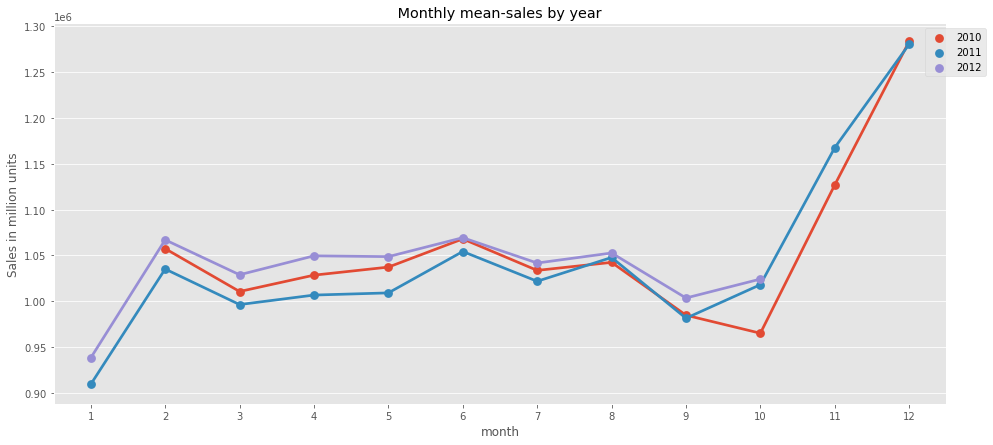

In [16]:
plt.figure(figsize=(16, 7))
tms = wm.loc[:,['Date','Weekly_Sales']]
tms['year'], tms['month'] = tms.Date.dt.year,  tms.Date.dt.month
sns.pointplot(data=tms, x=tms.month, y='Weekly_Sales', hue='year', ci=False) #estimator='mean'
plt.xlabel("month")
plt.ylabel("Sales in million units")
plt.title(" Monthly mean-sales by year ")
plt.legend(loc='upper right', bbox_to_anchor=(1.05,1))

In [17]:
tms[tms.year == 2010].groupby(['month'])['Weekly_Sales'].mean()

month
2     1057405.461333
3     1010665.569444
4     1028499.413556
5     1037282.968556
6     1068034.290889
7       1033689.4488
8       1042445.0605
9        984821.6465
10     965163.662311
11    1126963.167444
12    1283380.145422
Name: Weekly_Sales, dtype: Float64

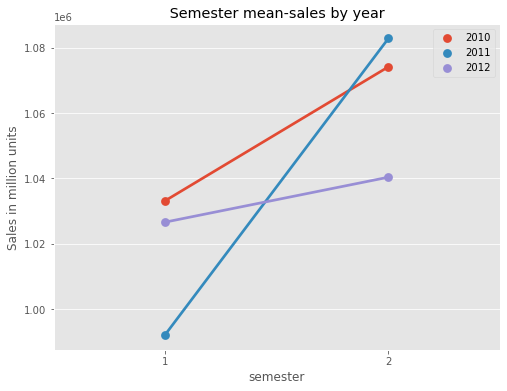

In [20]:
plt.figure(figsize=(8, 6))

tms['semester'] = (np.ceil((tms.Date.dt.month//6)/2 )+1).astype(int)
sns.pointplot(data=tms, x=tms.semester, y='Weekly_Sales', hue='year', ci=False) #estimator=sum
plt.xlabel("semester")
plt.ylabel("Sales in million units")
plt.title(" Semester mean-sales by year ")
plt.legend(loc='upper right') #, bbox_to_anchor=(1.15,1)
# np.ceil((np.arange(1,13)//6)/2).astype(int)+1

* ###  Bleak correlations of 'Weekly_Sales' with, 'Holiday_Flag','Temperature','Fuel_Price','CPI','Unemployment' 

<AxesSubplot:>

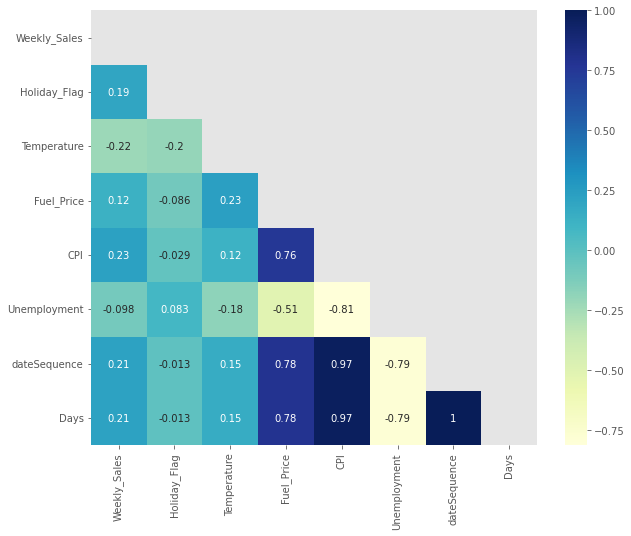

In [117]:
wm1 = wm[wm['Store']==1]
plt.figure(figsize=(10,8)) 
corr_check = wm1.loc[:,('Weekly_Sales','Holiday_Flag','Temperature','Fuel_Price','CPI','Unemployment')]
corr_check['dateSequence'] = np.arange(1,len(corr_check)+1)
corr_check['Days'] = ((wm1.Date - wm1.Date[0])/np.timedelta64(1, 'D'))+1

mask = np.triu(np.ones_like(corr_check.corr()))
sns.heatmap(corr_check.corr(), annot=True, cmap="YlGnBu", mask=mask)

In [182]:
# Least Squares for simple date replacement with 1 to length of the date feature
wm1 = wm[wm['Store']==1]
x =  wm1.loc[:,('Temperature','Fuel_Price','CPI','Unemployment')]
# x['reDate'] = ((wm1.Date - wm1.Date[0])/np.timedelta64(1, 'D'))+1
x['reDate'] = np.arange(1,len(x)+1)
for dty in x.columns: x[dty] = x[dty].astype(float)
y = wm1.Weekly_Sales.astype(float)
x_trainr, x_testr, y_trainr, y_testr = train_test_split(x, y, test_size=0.2, random_state=0)
model1 = OLS(y_trainr, x_trainr)
result_range = model1.fit()
result_range.summary()
#pvalues
# np.asarray(x), np.asarray(y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           Weekly_Sales   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              2483.
Date:                Mon, 31 Oct 2022   Prob (F-statistic):                   1.58e-110
Time:                        18:30:01   Log-Likelihood:                         -1516.4
No. Observations:                 114   AIC:                                      3043.
Df Residuals:                     109   BIC:                                      3056.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Temperature  -1954.5625   1009.396     -1.936      0.055   -3955.153      46.028
Fuel_Price   -4.766e+04   5.58e+04     -0.854      0.395   -1.58e+05    6.29e+04
CPI           5356.3022   2213.310      2.420      0.017     969.594    9743.010
Unemployment  7.708e+04    5.9e+04      1.306      0.194   -3.99e+04    1.94e+05
reDate        1219.1773    925.546      1.317      0.191    -615.225    3053.580
==============================================================================
Omnibus:                       82.749   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              656.668
Skew:                           2.354   Prob(JB):                    2.55e-143
Kurtosis:                      13.774   Cond. No.                     1.14e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [183]:
# Least Squares for simple date replacement with days
wm1 = wm[wm['Store']==1]
x =  wm1.loc[:,('Temperature','Fuel_Price','CPI','Unemployment')]
x['reDate'] = wm1.Date.dt.day #((wm1.Date - wm1.Date[0])/np.timedelta64(1, 'D'))+1
for dty in x.columns: x[dty] = x[dty].astype(float)
y = wm1.Weekly_Sales.astype(float)
x_traind, x_testd, y_traind, y_testd = train_test_split(x, y, test_size=0.2, random_state=0)
model1 = OLS(y_traind, x_traind)
result_days = model1.fit()
result_days.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           Weekly_Sales   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              2670.
Date:                Mon, 31 Oct 2022   Prob (F-statistic):                   3.15e-112
Time:                        18:30:06   Log-Likelihood:                         -1512.3
No. Observations:                 114   AIC:                                      3035.
Df Residuals:                     109   BIC:                                      3048.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Temperature  -2117.1798    965.954     -2.192      0.031   -4031.670    -202.690
Fuel_Price      60.8158   4.18e+04      0.001      0.999   -8.27e+04    8.28e+04
CPI           7848.8120   1503.143      5.222      0.000    4869.631    1.08e+04
Unemployment  9399.3603   3.07e+04      0.306      0.760   -5.15e+04    7.03e+04
reDate       -4862.9925   1538.923     -3.160      0.002   -7913.087   -1812.898
==============================================================================
Omnibus:                      117.482   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1755.259
Skew:                           3.534   Prob(JB):                         0.00
Kurtosis:                      20.877   Cond. No.                         780.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [177]:
print( 'date replacement with range::','r_square:', r2_score(y_testr,result_range.predict(x_testr)), 'MSE:', mean_squared_error(y_testr,result_range.predict(x_testr), squared=False))
print('date replacement with days::','r_square:', r2_score(y_testd,result_range.predict(x_testd)), 'MSE:', mean_squared_error(y_testd,result_range.predict(x_testd), squared=False))

date replacement with range:: r_square: 0.11618739392044375 MSE: 150128.07035111234
date replacement with days:: r_square: -0.6124791129589577 MSE: 202781.7447824636


+ ### eventhough correlation of CPI, unemployment, and fuel price to weekly_sales,
+ ### pvalues of unemployment, and fuel price > 0.05 suggests that it has higher bias on Weelky_sales predection.
+ ### Date replacement with range from 1 to length of Weelky_sales to have better MSE & r-square with LinearRegression Least Square fit model
## **------------------------------------------------------------------------------------------------------------------**

In [181]:
# wmdm0 = wm[wm['Store']==1]
# wmdm = wmdm0.drop(["Date"], axis=1)
# wmdm['redate'] = wmdm0.Date.dt.day #np.arange(1,len(x)+1) #((wm1.Date - wm1.Date[0])/np.timedelta64(1, 'D'))+1
# for dty in wmdm.columns: wmdm[dty] = wmdm[dty].astype(float)
# yDmat, xDmat = dmatrices('Weekly_Sales ~ Temperature + CPI + redate', data=wmdm, return_type='dataframe')
# x_traindm, x_testdm, y_traindm, y_testdm = train_test_split(xDmat, yDmat, test_size=0.2, random_state=0)
# model1 = OLS(y_traindm, x_traindm)
# resultOLS = model1.fit()
# resultOLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     6.934
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           0.000256
Time:                        18:28:05   Log-Likelihood:                -1512.3
No. Observations:                 114   AIC:                             3033.
Df Residuals:                     110   BIC:                             3044.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.261e+05   6.74e+05     -0.187      0.852   -1.46e+06    1.21e+06
Temperature -2162.8634    934.737     -2.314      0.023   -4015.293    -310.433
CPI          8781.4455   3157.093      2.781      0.006    2524.828     1.5e+04
redate      -4886.1215   1531.924     -3.190      0.002   -7922.035   -1850.208
==============================================================================
Omnibus:                      118.538   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1814.955
Skew:                           3.570   Prob(JB):                         0.00
Kurtosis:                      21.196   Cond. No.                     1.15e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
# x =  wm.loc[:,('Holiday_Flag','Temperature','Fuel_Price','CPI','Unemployment')]
# for dty in x.columns: x[dty].dtype = float
# y = wm.Weekly_Sales
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
# model1 = OLS(np.asarray(y_train, dtype=float), np.asarray(x_train, dtype=float))
# model = model1.fit()
# model.summary()

In [184]:
#y_testd #
# result_days.predict()